In [1]:
from skimage.io import imshow, imread_collection
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.feature import hog
import joblib 
from sklearn.model_selection import train_test_split
import numpy as np

class_names = ['spider', 'horse', 'elephant', 'chicken', 'cow']
path_to_image = 'raw-img/A_'
postfix = '_done/*.jpeg'

def create_data_set(data, class_name):
    for img in imread_collection(path_to_image + class_name + postfix):
        data['data'].append(resize(img, (64,128)))
        data['labels'].append(class_name)



data = dict()
data['data'] = []
data['labels'] = []

for class_name in class_names:
    create_data_set(data, class_name)


joblib.dump(data, 'img.pkl')

['img.pkl']

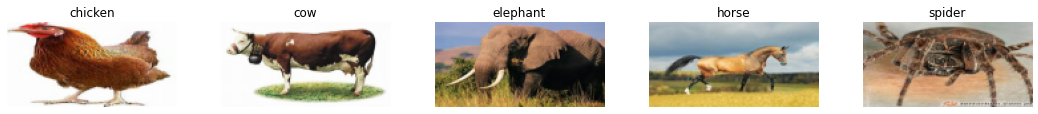

In [2]:
import matplotlib.pyplot as plt

#data = joblib.load('img.pkl')
labels = np.unique(data['labels'])
 

# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['labels'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

In [3]:
X = np.array(data['data'])
y = np.array(data['labels'])

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)

In [4]:
from sklearn.preprocessing import StandardScaler, Normalizer
scalify = StandardScaler()

hog_train = scalify.fit_transform(np.array([hog(img, orientations=10, pixels_per_cell=(8,8), cells_per_block=(6, 6),multichannel=True) for img in X_train]))


/tmp/ipykernel_25458/4179363378.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_train = scalify.fit_transform(np.array([hog(img, orientations=10, pixels_per_cell=(8,8), cells_per_block=(6, 6),multichannel=True) for img in X_train]))


/tmp/ipykernel_25458/477337268.py:12: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, img = hog(data['data'][idx], orientations=8, pixels_per_cell=(8,8), cells_per_block=(6,6), visualize=True, multichannel=True)


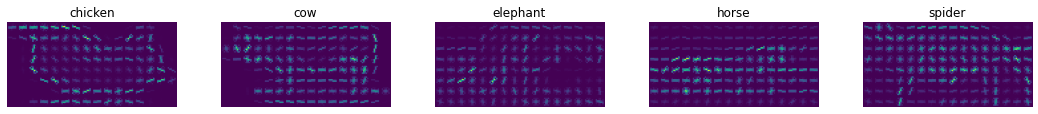

In [5]:
from skimage.transform import integral_image
from skimage import exposure,feature


fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 

for ax, label in zip(axes, labels):
    idx = data['labels'].index(label)
    fd, img = hog(data['data'][idx], orientations=8, pixels_per_cell=(8,8), cells_per_block=(6,6), visualize=True, multichannel=True) 
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(label)

In [6]:
from sklearn import svm

mlp_classifier = svm.SVC()

mlp_classifier.fit(hog_train, y_train)

SVC()

In [7]:

hog_test = scalify.fit_transform(np.array([hog(img, orientations=10, pixels_per_cell=(8,8), cells_per_block=(6, 6), multichannel=True) for img in X_test]))
labels_predicted = mlp_classifier.predict(hog_test)

print('Percentage correct: ', 100*np.sum(labels_predicted == y_test)/len(y_test))



/tmp/ipykernel_25458/2345218367.py:1: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_test = scalify.fit_transform(np.array([hog(img, orientations=10, pixels_per_cell=(8,8), cells_per_block=(6, 6), multichannel=True) for img in X_test]))


[ True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]

Percentage correct:  82.65306122448979


              precision    recall  f1-score   support

     chicken       0.91      0.84      0.87        82
         cow       0.81      0.68      0.74        57
    elephant       0.75      0.68      0.71        44
       horse       0.78      0.89      0.83       118
      spider       0.86      0.89      0.88        91

    accuracy                           0.83       392
   macro avg       0.82      0.80      0.81       392
weighted avg       0.83      0.83      0.83       392

[[ 69   3   1   5   4]
 [  1  39   5   8   4]
 [  1   1  30  12   0]
 [  1   4   3 105   5]
 [  4   1   1   4  81]]


'elephant'

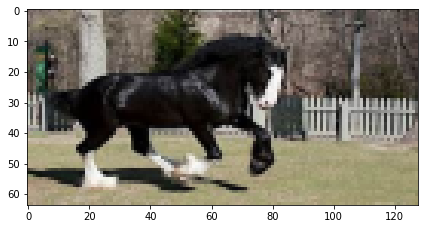

In [8]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, labels_predicted))
print(confusion_matrix(y_test, labels_predicted))

imshow(X_test[2])
labels_predicted[2]

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
 
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(10, 10), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', svm.SVC(random_state=42, max_iter=1000, tol=1e-3))
])



In [10]:
from sklearn.model_selection import GridSearchCV
 
param_grid = [
    {
        'hogify__orientations': [8, 9, 10, 11],
        'hogify__cells_per_block': [(2,2), (3, 3),(4,4),(6,6)],
        'hogify__pixels_per_cell': [(6,6),(8, 8), (4,4),(9,9)]
    }
]

grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid, 
                           n_jobs=2)
 
grid_res = grid_search.fit(X_train, y_train)

In [ ]:
joblib.dump(grid_res, 'hog_sgd_model.pkl');
grid_res.best_estimator_
grid_res.best_score_



In [ ]:
best_pred = grid_res.predict(X_test)
print('Percentage correct: ', 100*np.sum(best_pred == y_test)/len(y_test))